### E01
Train a **trigram language model**, i.e. take two characters as an input to predict the 3rd one. 

Feel free to use either counting or a neural net. 

Evaluate the loss; Did it improve over a bigram model?

In [27]:
# Load the dataset into a list
with open('names.txt', 'r') as file:
    names = file.read().split()

print('Total names:', len(names))
print(min(len(item) for item in names), max(len(item) for item in names))

Total names: 32033
2 15


In [28]:
import torch

# Initialize a zero count 3D tensor. Keep the data type as int for count
N = torch.zeros(27, 27, 27, dtype=torch.int)
N.shape

torch.Size([27, 27, 27])

In [29]:
# Form stoi and itos
vocab = sorted(list(set(''.join(names))))
stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi['.'] = 0
itos = {stoi[s]: s for s in stoi}

In [30]:
# Filling in the count matrix N
for name in names:
    name = ['.'] + list(name) + ['.']
    for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
        N[stoi[ch1], stoi[ch2], stoi[ch3]] += 1

In [31]:
N[0, 1, :]

tensor([  0, 207, 190,  31, 366,  55,  21,  17,  91, 154,  27,  75, 632, 384,
        623,  10,  17,   9, 482, 194,  72, 152, 243,   6,  27, 173, 152],
       dtype=torch.int32)

In [32]:
# Test: Calculating probability for just one row: names starting with '.a'
p = N[0, 1, :].float()

p /= p.sum()

p, p.sum() # sum of a row should be 1 if calculated correctly

(tensor([0.0000, 0.0469, 0.0431, 0.0070, 0.0830, 0.0125, 0.0048, 0.0039, 0.0206,
         0.0349, 0.0061, 0.0170, 0.1433, 0.0871, 0.1413, 0.0023, 0.0039, 0.0020,
         0.1093, 0.0440, 0.0163, 0.0345, 0.0551, 0.0014, 0.0061, 0.0392, 0.0345]),
 tensor(1.))

In [37]:
# Calculating probability for all the possibilities
P = (N+1).float()

P /= P.sum(2, keepdim=True)

In [34]:
# It is almost identical to probability for just one row: names starting with '.a' that we calculated earlier
# Difference because of normalization using +1 in the block above
P[0, 1, :] 


tensor([0.0002, 0.0469, 0.0430, 0.0072, 0.0827, 0.0126, 0.0050, 0.0041, 0.0207,
        0.0349, 0.0063, 0.0171, 0.1427, 0.0868, 0.1406, 0.0025, 0.0041, 0.0023,
        0.1089, 0.0439, 0.0165, 0.0345, 0.0550, 0.0016, 0.0063, 0.0392, 0.0345])

In [39]:
# g = torch.Generator().manual_seed(2147483647) # optional to generate same names for every execution

# Generating random names
out_names = []
for _ in range(5):
    ind1 = 0
    ind2 = 0
    curr = []
    while True:
        # P = N[ind].float()/sum(N[ind])
        ind3 = torch.multinomial(P[ind1, ind2], num_samples=1).item()
        # P[ind1, ind2, ind3] is the real probability
        if ind3 == 0:
            out_names.append(''.join(curr))
            break
        curr.append(itos[ind3])
        ind1, ind2 = ind2, ind3

out_names

['shtae', 'sy', 'mii', 'rh', 'toryn']

In [40]:
# Calculate loss function

log_likelihood = 0.0 # sum of logs
total_trigrams = 0
for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
        ind1 = stoi[ch1]
        ind2 = stoi[ch2]
        ind3 = stoi[ch3]
        prob = P[ind1, ind2, ind3]
        logprob = torch.log(prob) # This is more negative on lower probabilities
        # print(ch1+ch2+ch3, f'{prob:.4f}', f'{logprob:.4f}')
        log_likelihood += logprob.item()
        total_trigrams += 1

nll = -log_likelihood # Goal is to minimize loss function
nll /= total_trigrams # in practice we normalize it by total number of bigrams

print(f'{total_trigrams=}')
print(f'{log_likelihood=}')
print(f'{nll=}')

total_trigrams=196113
log_likelihood=-410480.1699063033
nll=2.0930798565434383


### Neural network framework

- Initialize xs ( 27 * 27 ) and corresponding ys ( 27 )
- Initialize weights with normalized normal values. Dimensions should be 27 * 27. Let's keep number of neurons to be 27 as well. 

In [41]:
# Populate training data
xs, ys = [], []
for name in names:
    name = ['.'] + list(name) + ['.']
    for ch1, ch2, ch3 in zip(name, name[1:], name[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [50]:
print(xs.shape, ys.shape)
print(xs[0])
print(itos[xs[0, 0].item()], itos[xs[0, 1].item()], itos[ys[0].item()])

torch.Size([196113, 2]) torch.Size([196113])
tensor([0, 5])
. e m


In [42]:
# One hot encoding of the inputs
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # casting to float32 to match dtype of Weight
xenc = xenc.view(xenc.shape[0], 2*27) 
yenc = F.one_hot(ys, num_classes=27).float()

num = ys.nelement()

In [43]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27*2, 27, generator=g, requires_grad=True)

In [44]:
print(xenc.shape, W.shape)

torch.Size([196113, 54]) torch.Size([54, 27])


In [45]:
# Forward pass
logits = (xenc @ W)
counts = logits.exp()
# Normalize the count to get probability distribution
probs = counts / counts.sum(1, keepdims=True)

In [105]:
print(probs.shape)

print(probs[0].sum(), num)

torch.Size([196113, 27])
tensor(1.0000, grad_fn=<SumBackward0>) 196113


In [107]:
torch.arange(num)
ys

tensor([13, 13,  1,  ..., 26, 24,  0])

In [46]:
loss = -probs[torch.arange(num), ys].log().mean()
print(loss.item())

4.186271667480469


In [109]:
probs.shape

torch.Size([196113, 27])

In [49]:
## Sampling
for _ in range(5):
    curr = []
    ind1, ind2 = 0, 0
    while True:
        # ind3 = torch.multinomial(probs[ind1, ind2], num_samples=1).item()
        pair = torch.tensor([[ind1, ind2]])
        xenc1 = F.one_hot(torch.tensor(pair), num_classes=27).float()
        xenc1 = xenc1.view(1, 2*27) 
        logit = xenc1 @ W
        counts = logit.exp()
        p = counts / counts.sum(1, keepdims=True) # probablity of next character
        # Sample
        ind3 = torch.multinomial(p, num_samples=1, generator=g, replacement=True).item()
        if ind3 == 0:
            break
        curr.append(itos[ind3])
        ind1, ind2 = ind2, ind3
    print(''.join(curr))

ongbdupejrwlllewr
nbrwusdvqkppgudhlbqmpxozgikqavyaxrsnc
addznuw
yydhaktr
kzvv


/var/folders/jj/_5c22x614_d4cb5qrlyt0rhh0000gn/T/ipykernel_77265/475452532.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xenc1 = F.one_hot(torch.tensor(pair), num_classes=27).float()


In [ ]:
losses = []

2.332667350769043
2.3295230865478516
2.3265652656555176
2.3237786293029785
2.3211495876312256
2.3186655044555664
2.316315174102783
2.314089059829712
2.3119773864746094
2.3099725246429443


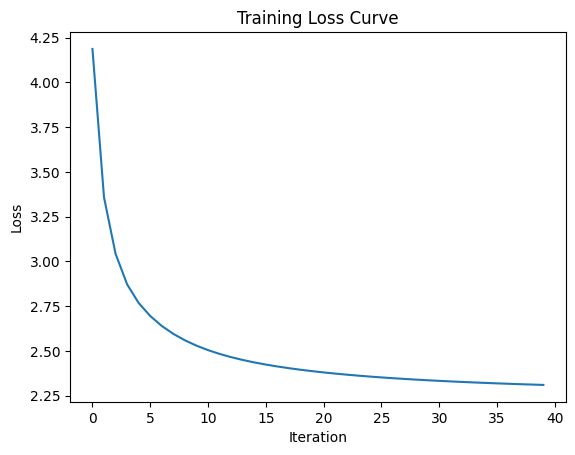

In [ ]:
import matplotlib.pyplot as plt

for _ in range(10):
    # Forward pass
    logits = (xenc @ W)
    counts = logits.exp()
    # Normalize the count to get probability distribution
    probs = counts / counts.sum(1, keepdims=True)

    # print(torch.arange(num))
    # print(ys.shape)
    # print(logits.shape, probs.shape)
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())
    losses.append(loss.item())
    # Backward pass
    W.grad = None
    loss.backward()
    
    # Update the weights
    W.data += -50 * W.grad

# Plot
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Bigram training Loss Curve")
plt.show()